## <center>Boston Crime Forecasting (June 2015- September 2018)
### <center>Anil Abraham 2023

#### <center>The goal of this project is to use machine learning techniques to forecast crime in Boston. Particularly, forecasting type of crime, number of crimes committed in a year, and crime hotspots/locations.

### Brief explanation of each column:
<ul>
<li>INCIDENT_NUMBER - File number</li>
<li>OFFENSE_CODE - Code of specific crime</li>
<li>OFFENSE_CODE_GROUP - Name of crime</li>
<li>OFFENSE_DESCRIPTION - Detailed information about crime</li>
<li>DISTRICT - Boston neighbourhood</li>
<li>REPORTING_AREA - Area defined by Boston PD</li>
<li>SHOOTING - 'Y' represents a shooting occurence</li>
<li>OCCURRED_ON_DATE/YEAR/MONTH/DAY_OF_WEEK/HOUR - Date of crime</li>
<li>UCR_PART - Severity of the crime (highest is 1)</li>
<li>STREET/Lat/Long/Location - Location</li>
</ul>

### <u>Importing libraries</u>

In [2]:
import pandas as pd #Pandas for data manipulation and analysis
import numpy as np #Numpy for matrices
import geopandas as gpd #Support for geospatial data
from shapely.geometry import Point #Geographic information systems functions and analysis
import matplotlib.pyplot as plt #Matplotlib for visualisations
import seaborn as sns
import plotly.express as px
sns.set_style("darkgrid")
#pd.set_option('display.max_rows', None)

### <u>Loading dataset</u>

In [3]:
df = pd.read_csv('crime.csv', encoding='latin') #Thousands are seperated by commas in the CSV.

for col in df.columns.to_list(): #List all feature names
    print(col)
df.shape

INCIDENT_NUMBER
OFFENSE_CODE
OFFENSE_CODE_GROUP
OFFENSE_DESCRIPTION
DISTRICT
REPORTING_AREA
SHOOTING
OCCURRED_ON_DATE
YEAR
MONTH
DAY_OF_WEEK
HOUR
UCR_PART
STREET
Lat
Long
Location


(319073, 17)

### <u>Data preprocessing</u>

#### Only certain columns are of interest to us, so let's drop the rest.

In [4]:
df.drop(['Location', 'OFFENSE_CODE'], inplace=True, axis=1)

In [5]:
df['DISTRICT'].nunique()

12

#### Check for null values

In [6]:
print(f'Null values found\n{df.isna().sum()}') #Check for null values

Null values found
INCIDENT_NUMBER             0
OFFENSE_CODE_GROUP          0
OFFENSE_DESCRIPTION         0
DISTRICT                 1765
REPORTING_AREA              0
SHOOTING               318054
OCCURRED_ON_DATE            0
YEAR                        0
MONTH                       0
DAY_OF_WEEK                 0
HOUR                        0
UCR_PART                   90
STREET                  10871
Lat                     19999
Long                    19999
dtype: int64


#### Fill null values

In [7]:
df['SHOOTING'].fillna('N', inplace=True) #Null shootings should be replaced with 'N'

df.loc[df['STREET'].isna(), ('STREET')] = 'Unknown' #Null STREET should be replaced with unknown
df.loc[df['Lat'].isna(), ('STREET')] = 'Unknown'
df.loc[df['Lat'].isna(), ('Lat')] = 42.31 #All null locations are replaced with a unique location
df.loc[df['Long'].isna(), ('Long')] = -71.17

df.loc[df['Lat'] == -1, ('STREET')] = 'Unknown'
df.loc[df['Lat'] == -1, ('Lat')] = 42.31 #All null locations are replaced with a unique location
df.loc[df['Long'] == -1, ('Long')] = -71.17

df.loc[df['UCR_PART'].isna(), ('UCR_PART')] = 'Other' #Replace all null UCR_PART with Other
df.loc[df['DISTRICT'].isna(), ('DISTRICT')] = 'Unknown' #Replace all null DISTRICT with Unknown

#### Check for duplicates

In [8]:
print(f'Before checking for duplicates\n{df.duplicated().sum()}')
df.drop_duplicates(inplace=True) #Drop all duplicates
print(f'\nAfter checking for duplicates\n{df.duplicated().sum()}')

Before checking for duplicates
24

After checking for duplicates
0


#### Check for duplicate INCIDENT_NUMBER

In [9]:
df[df['INCIDENT_NUMBER'] == 'I152030570-00'] #One such example of an INCIDENT_NUMBER being repeated

,INCIDENT_NUMBER,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long
318742,I152030570-00,Warrant Arrests,WARRANT ARREST,E13,303,N,2016-10-29 08:25:00,2016,10,Saturday,8,Part Three,W WALNUT PARK,42.317207,-71.098799
318743,I152030570-00,Aggravated Assault,ASSAULT & BATTERY D/W - OTHER,E13,303,N,2016-10-29 08:25:00,2016,10,Saturday,8,Part One,W WALNUT PARK,42.317207,-71.098799
318744,I152030570-00,Aggravated Assault,"A&B HANDS, FEET, ETC. - MED. ATTENTION REQ.",E13,303,N,2016-10-29 08:25:00,2016,10,Saturday,8,Part One,W WALNUT PARK,42.317207,-71.098799


##### Cases can have multiple crimes committed per incident, such as the one above. All the crimes belong to the same case, therefore it isn't a duplicate

#### Convert categories

In [10]:
df['DAY_OF_WEEK'] = pd.Categorical(df['DAY_OF_WEEK'],  #Convert to category to save memory
              categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
              ordered=True)

#### Convert OCCURED_ON_DATE to pandas datetime object, and convert index to DatetimeIndex

In [11]:
df['OCCURRED_ON_DATE'] = pd.to_datetime(df['OCCURRED_ON_DATE']) #Convert this column to pandas datatype 'datetime'
df.index = pd.DatetimeIndex(df['OCCURRED_ON_DATE']) #Converting index to a DatetimeIndex instead
df.drop(['OCCURRED_ON_DATE'], axis=1, inplace=True) #Drop the OCCURED_ON_DATE column

#### What are the datatypes used?

In [12]:
df.dtypes

INCIDENT_NUMBER          object
OFFENSE_CODE_GROUP       object
OFFENSE_DESCRIPTION      object
DISTRICT                 object
REPORTING_AREA           object
SHOOTING                 object
YEAR                      int64
MONTH                     int64
DAY_OF_WEEK            category
HOUR                      int64
UCR_PART                 object
STREET                   object
Lat                     float64
Long                    float64
dtype: object

#### High-level stats of the Boston dataframe

In [13]:
df.describe()

,YEAR,MONTH,HOUR,Lat,Long
count,319049.000000,319049.000000,319049.000000,319049.000000,319049.000000
mean,2016.560676,6.609621,13.118161,42.321498,-71.088516
std,0.996313,3.273682,6.294262,0.030977,0.035922
min,2015.000000,1.000000,0.000000,42.232413,-71.178674
25%,2016.000000,4.000000,9.000000,42.299442,-71.104292
50%,2017.000000,7.000000,14.000000,42.321060,-71.079725
75%,2017.000000,9.000000,18.000000,42.347174,-71.063289
max,2018.000000,12.000000,23.000000,42.395042,-70.963676


#### Let's look at the first and last 3 records of the dataset

In [14]:
pd.concat([df.sort_index().head(3), df.sort_index(ascending=False).head(3)])

,INCIDENT_NUMBER,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long
OCCURRED_ON_DATE,,,,,,,,,,,,,,
2015-06-15 00:00:00,I162013546,Property Lost,PROPERTY - LOST,B3,433,N,2015,6,Monday,0,Part Three,NORFOLK ST,42.283634,-71.082813
2015-06-15 00:00:00,I152051083,Search Warrants,SEARCH WARRANT,A7,20,N,2015,6,Monday,0,Part Three,PARIS ST,42.377023,-71.032247
2015-06-15 00:00:00,I152049897,Property Lost,PROPERTY - LOST,B2,282,N,2015,6,Monday,0,Part Three,WASHINGTON ST,42.328663,-71.085634
2018-09-03 21:25:00,I182070933,Auto Theft,AUTO THEFT,B2,330,N,2018,9,Monday,21,Part One,NORMANDY ST,42.306072,-71.082733
2018-09-03 21:16:00,I182070940,Investigate Property,INVESTIGATE PROPERTY,D4,272,N,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664
2018-09-03 21:09:00,I182070936,Motor Vehicle Accident Response,M/V ACCIDENT INVOLVING PEDESTRIAN - INJURY,C11,398,N,2018,9,Monday,21,Part Three,TALBOT AVE,42.290196,-71.071590


#### Crimes types grouped by UCR_PART

In [15]:
for i, g in df.groupby(['UCR_PART'], observed=True)['OFFENSE_CODE_GROUP'].unique().items():
    print(i, "\n", g, '\n') #List all crimes grouped by their UCR_PART

Other 
 ['Arson' 'License Plate Related Incidents' 'Auto Theft Recovery'
 'HOME INVASION' 'Other' 'Manslaughter' 'INVESTIGATE PERSON'
 'HUMAN TRAFFICKING' 'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE'
 'Burglary - No Property Taken'] 

Part One 
 ['Larceny' 'Auto Theft' 'Robbery' 'Larceny From Motor Vehicle'
 'Residential Burglary' 'Aggravated Assault' 'Other Burglary'
 'Commercial Burglary' 'Homicide'] 

Part Three 
 ['Towed' 'Investigate Property' 'Motor Vehicle Accident Response'
 'Verbal Disputes' 'Fire Related Reports' 'Property Lost'
 'Medical Assistance' 'Assembly or Gathering Violations' 'Property Found'
 'Police Service Incidents' 'Warrant Arrests' 'Other'
 'Property Related Damage' 'Missing Person Reported' 'Investigate Person'
 'License Plate Related Incidents' 'Harbor Related Incidents'
 'Firearm Discovery' 'Landlord/Tenant Disputes' 'Missing Person Located'
 'Service' 'Search Warrants' 'License Violation' 'Explosives' 'Aircraft'
 'Prisoner Related Incidents'] 

Part Two 
 ['

##### Part One crimes are the most severe, including crimes such as homicide, aggravated assault, and auto theft. Part three crimes are the least severe, including crimes such as person investigation and license violations.

### <u>Exploratory Data Analysis</u>

#### Seasonality analysis

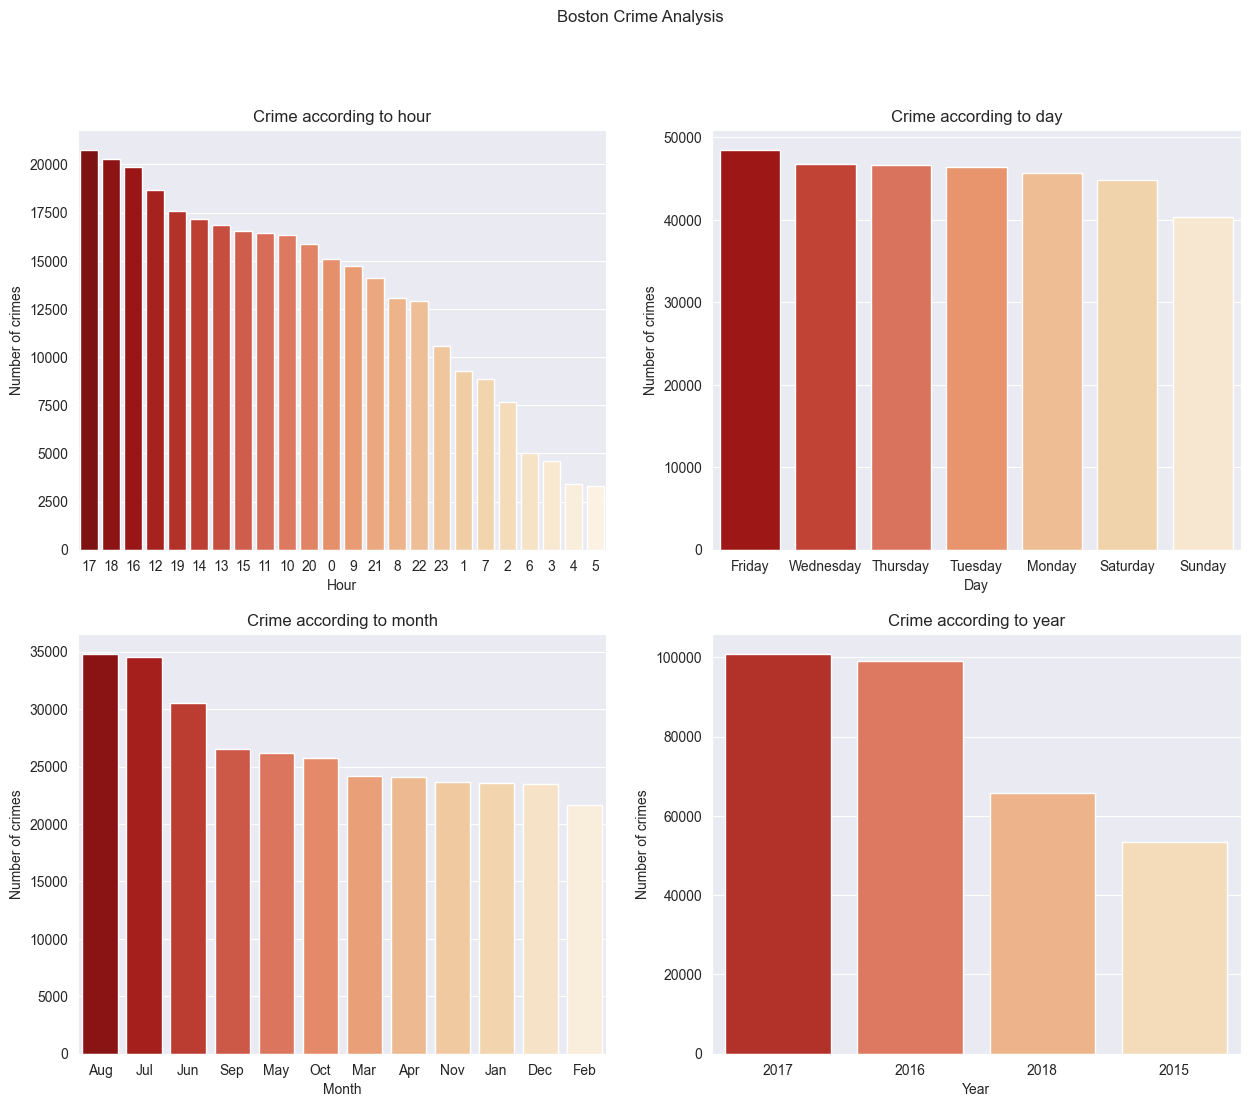

In [16]:
import calendar

df_hours = df.groupby(['HOUR'], observed=True).count()['INCIDENT_NUMBER'].sort_values(ascending=False) #Group number of crimes committed per HOUR in descending order
df_week = df.groupby(['DAY_OF_WEEK'], observed=True).count()['INCIDENT_NUMBER'].sort_values(ascending=False) #Group number of crimes committed per WEEK in descending order
df_month = df.groupby(['MONTH'], observed=True).count()['INCIDENT_NUMBER'].sort_values(ascending=False) #Group number of crimes committed per MONTH in descending order
df_year = df.groupby(['YEAR'], observed=True).count()['INCIDENT_NUMBER'].sort_values(ascending=False) #Group number of crimes committed per YEAR in descending order

df_month = df_month.reset_index()
df_month['MONTH'] = df_month['MONTH'].apply(lambda x: calendar.month_abbr[x]) #Convert number representation of month (8) to string (August)

fig, axs = plt.subplots(2, 2, figsize=(15, 12))

sns.barplot(x=df_hours.index, y=df_hours.values, order=df_hours.index, palette="OrRd_r", ax = axs[0,0]) #Using barplots to visualise the grouped data
sns.barplot(x=df_week.index, y=df_week.values, order=df_week.index, palette="OrRd_r", ax = axs[0,1])
sns.barplot(data=df_month, x='MONTH', y='INCIDENT_NUMBER', palette="OrRd_r", ax = axs[1,0])
sns.barplot(x=df_year.index, y=df_year.values, order=df_year.index, palette="OrRd_r", ax = axs[1,1])

axs[0,0].set_title('Crime according to hour')
axs[0,0].set_xlabel('Hour')
axs[0,0].set_ylabel('Number of crimes')

axs[0,1].set_title('Crime according to day')
axs[0,1].set_xlabel('Day')
axs[0,1].set_ylabel('Number of crimes')

axs[1,0].set_title('Crime according to month')
axs[1,0].set_xlabel('Month')
axs[1,0].set_ylabel('Number of crimes')

axs[1,1].set_title('Crime according to year')
axs[1,1].set_xlabel('Year')
axs[1,1].set_ylabel('Number of crimes')

fig.suptitle('Boston Crime Analysis') #Main title
plt.show()

##### The above EDA suggests that most crimes in Boston from 2015-2018 took place between 4pm-6pm, with most crimes occurring on Fridays. The data suggests that most crimes in Boston took place in August and July, and that the years 2018 and 2015 saw a reduction in crime. This cannot be assumed to be true, as this crime dataset recorded data from June 2015 to September 2018, meaning we have a full years worth of data for 2017 and 2016 and half a years worth of data for 2018 and 2015. Hence, we are missing data from Jan 2015 - May 2015 and October 2018 - Dec 2018.

#### Analysis of crimes

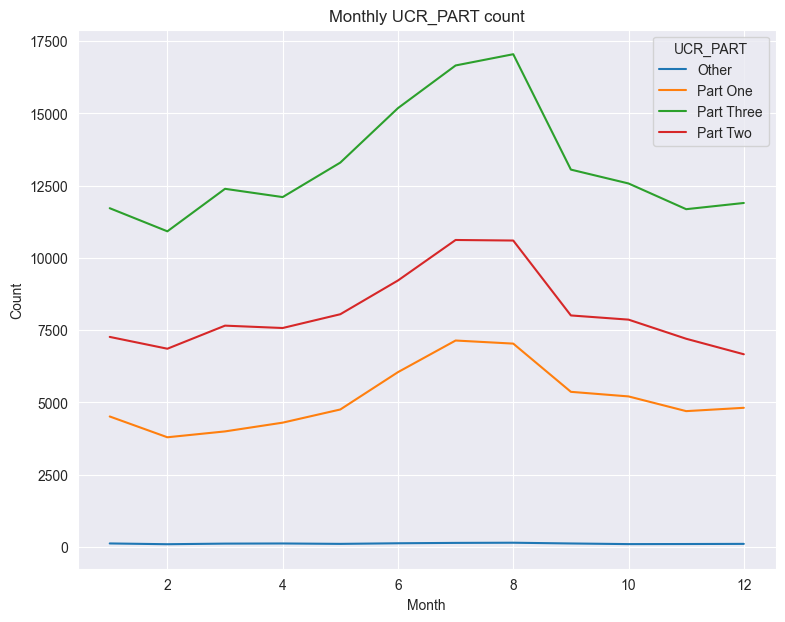

In [17]:
plt.figure(figsize=(9,7))

df_time = df.groupby(['UCR_PART', df.index.month], observed=True)['INCIDENT_NUMBER'].count().reset_index(name="Count") #Number of crimes committed over the years, according to their UCR_PART category

sns.lineplot(df_time, x='OCCURRED_ON_DATE', y='Count', hue='UCR_PART') #Line plot of grouped data

plt.title('Monthly UCR_PART count')

plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

##### Most crimes taking place in Boston between 2015 and 2018 were classified as Part 3 crimes, which include less severe crimes such as towing and license violations. Crimes are peaking in June, July, and August.

#### <mark>Crime trends in Boston (2015-2018)

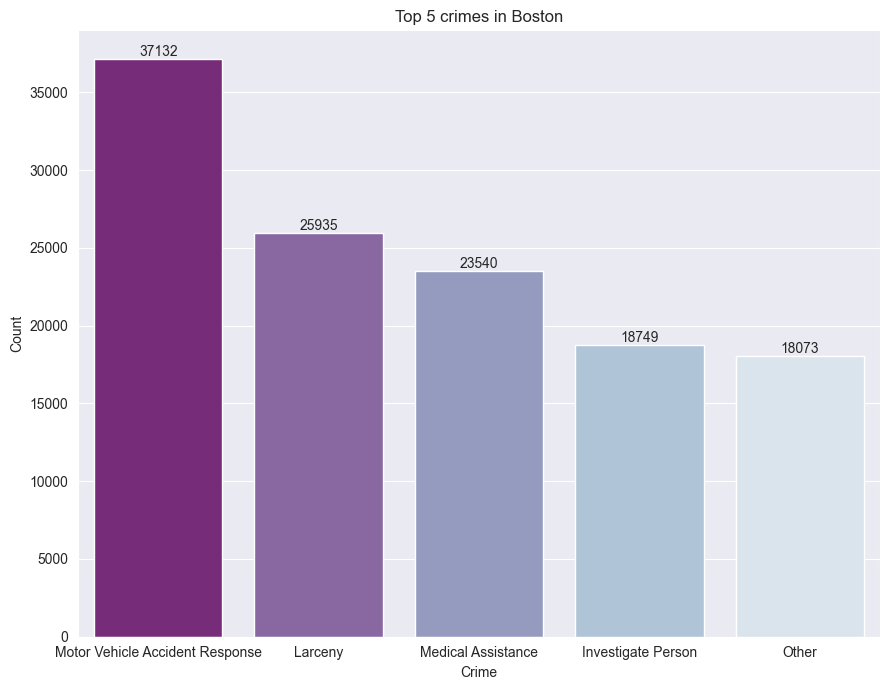

In [18]:
df_top5 = df.groupby(['OFFENSE_CODE_GROUP'], observed=True).count()['INCIDENT_NUMBER'].sort_values(ascending=False)[:5] #The top 5 crimes committed

plt.figure(figsize=(9,7))

ax = sns.barplot(x=df_top5.index, y=df_top5.values, order=df_top5.index, palette="BuPu_r") #Bar plot of grouped data

for i in ax.containers:
    ax.bar_label(i,) #Display the value above the barplot
    
plt.title('Top 5 crimes in Boston')
plt.ylabel('Count')
plt.xlabel('Crime')
plt.tight_layout()
plt.show()

##### The top 5 crimes in Boston for these years were: Motor vehicle accident responses, larceny, medical assistance crimes, investigate person, and other.

#### Interactive heatmap of crimes in Boston

In [19]:
#Create heatmap dataframe
step = 0.01
to_bin = lambda x: np.floor(x / step) * step #Grouping Latitude/longitude per 0.01 step so as to identify hotspots.
heatmap = df.copy()
heatmap["Lat"] = to_bin(df["Lat"])
heatmap["Long"] = to_bin(df["Long"])
heatmap = heatmap.groupby(["Lat", "Long", "STREET"]).count()['INCIDENT_NUMBER'].reset_index(name='Count')
heatmap = heatmap[heatmap["STREET"] != "Unknown"] #The heatmap will list the Unknown location as a hotspot as there are a large number of unknown locations, therefore we remove this from visualisation.

def first_occurrence(series):
    return series.iloc[0] #Return only the first occurence of the lat/long pair so we can sum the count

heatmap = heatmap.sort_values("Count", ascending=False).groupby('STREET')\
    .agg({'Lat': first_occurrence, 'Long': first_occurrence, 'Count': 'sum'}).reset_index().sort_values("Count", ascending=False) #The same street occurs for various lat/long coord pairs, therefore we sum them up to get one result.

heatmap = heatmap[heatmap['Count'] > 200] #Limit to areas with high crime counts

In [20]:
#Plotting
fig = px.scatter_mapbox(heatmap, lat="Lat", lon="Long", hover_name="STREET", hover_data=["Count"],
                        color="Count", color_continuous_scale=['Yellow', 'orange', 'red', 'maroon'], zoom=11, height=700, size='Count', size_max=35)
fig.update_layout(mapbox_style="carto-darkmatter", margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

##### The above interactive map depicts major hotspots as large red circles. These hotspots are identified in the following barplot. The larger/redder the circle, the more crimes were committed in that area. Most hotspots are overlapping due to the latitude/longitude binning, as there may be many streets within a latitude/longitude step (0.01).

### Static heatmap of Chicago crime hotspots

##### Create geodataframe

In [25]:
heatmap_top5 = heatmap.sort_values("Count", ascending=False)[:5]
heatmap_top5['Size'] = heatmap_top5['Count'] / 10 #Adjusting bubble marker size

geo_df = gpd.GeoDataFrame(heatmap_top5, geometry=[Point(xy) for xy in zip(heatmap_top5['Long'], heatmap_top5['Lat'])]) #Creation of geodf

##### Plot

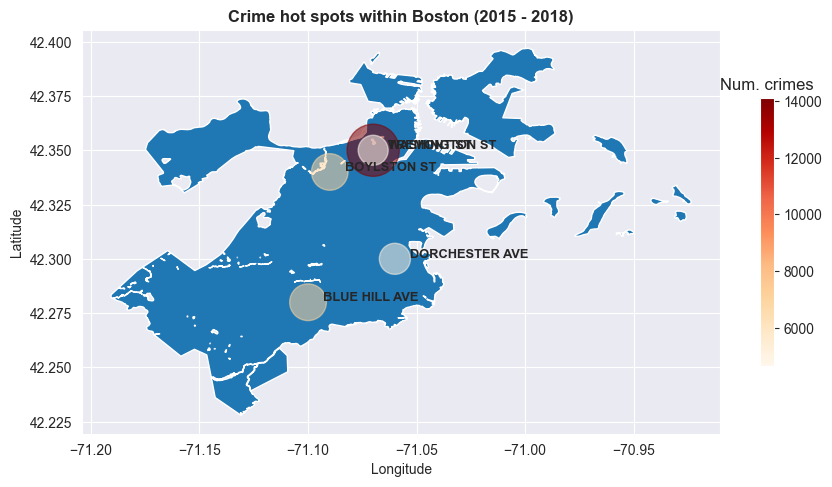

In [30]:
fig, ax = plt.subplots(figsize=(9,7))
map = gpd.read_file("City_of_Boston_Boundary.geojson") #Read in geojson file
map.plot(ax=ax, aspect=1) #Plot geojson file
geo_df.plot(aspect=1, column='Count', markersize='Size', ax=ax, cmap='OrRd', legend=True, alpha=0.55, legend_kwds={'shrink': 0.4}) #Plot the latitude longitude pairs onto the same Boston map.

for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df['STREET']):
    ax.annotate(label, xy=(x, y), xytext=(11,1), textcoords="offset points", weight='bold', fontsize=9.3) #Labelling each hotspot

ax.get_figure().get_axes()[1].set_title("Num. crimes") #Set legend title
plt.title('Crime hot spots within Boston (2015 - 2018)', weight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

#### Barplot of Top 5 hotspots in Boston

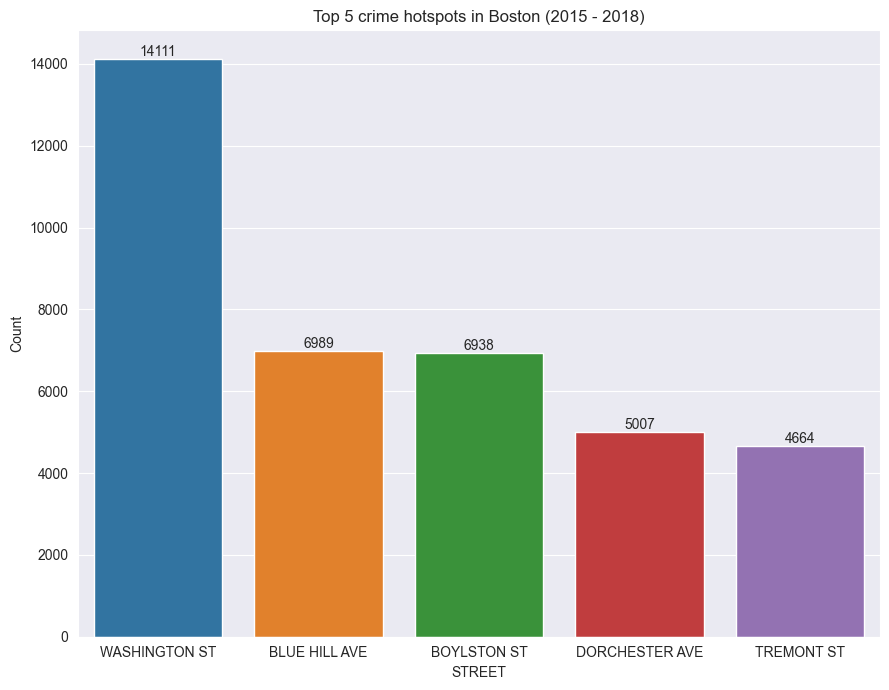

In [27]:
plt.figure(figsize=(9,7))
ax = sns.barplot(heatmap_top5, x='STREET', y='Count') #Barplot of top 5 hotspots

for i in ax.containers:
    ax.bar_label(i,) #Depict crime count over each bar
    
plt.title("Top 5 crime hotspots in Boston (2015 - 2018)")
plt.tight_layout()
plt.show()

##### According to the heatmap and barplot above, most crimes in Boston from 2015 - 2018 were committed in Washington Street, Blue Hill Avenue, and Bolyston Street.

### <u>Machine Learning</u>

#### Import

In [23]:
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from catboost import CatBoostClassifier, cv, Pool
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from time import process_time
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from joblib import dump, load

#### Data aquisition

In [24]:
X = df.loc[:, ('REPORTING_AREA', 'UCR_PART', 'MONTH', 'DAY_OF_WEEK', 'HOUR')] #Not including Latitude and Longitude because most models will get near perfect accuracy AKA overfitting.
y = df['DISTRICT'] #Predicting the DISTRICT

#### Sampling/split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42) #80% train, 20% test

#### Categorical encoding

In [26]:
oe = OrdinalEncoder()
X_train_transformed = oe.fit_transform(X_train)
X_test_transformed = oe.transform(X_test)

#### Hyperparameter space

In [27]:
rand_grid = { #Random forest grid
 'min_samples_leaf': [1, 2, 3],
 'min_samples_split': [2, 3, 4],
 'n_estimators': [20, 50, 100, 200]}

decision_grid = { #Decision tree grid
    'criterion': ['gini', 'entropy'],        
    'splitter': ['best', 'random'],           
    'min_samples_split': [2, 5, 10],         
    'min_samples_leaf': [1, 2, 4],           
    'max_features': ['sqrt', 'log2'],                  
}

NB_grid = { #Gaussian Naive Bayes grid
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

knn_grid = { #k-NN grid
    'n_neighbors': [3, 5, 7, 9],        
    'weights': ['uniform', 'distance'], 
    'p': [1, 2],                        
    'metric': ['euclidean', 'manhattan']
}

ada_grid = { #AdaBoost grid
    'n_estimators': [50, 100, 200],  
    'learning_rate': [0.1, 0.5, 1.0]
}

cat_grid = { #CatBoost grid
    'iterations': 1000,      
    'learning_rate': 0.05, 
    'depth': 6,                  
    'l2_leaf_reg': 5,             
    'border_count': 64,
    "loss_function": "MultiClass"
}

xg_grid = { #XGBoost grid
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4, 5, 6]
        }

space = [rand_grid,decision_grid, cat_grid, ada_grid, NB_grid, knn_grid, xg_grid] #List of grids

#### Algorithm training

In [28]:
#Handles the results dataframe
def appendToDf(avg, std, y_pred, y_test, name, results):
    '''Groups the results of each classifier into a pandas dataframe'''

    avg = round(avg.mean()*100, 2) #Average and standard deviation of CV results
    std = round(std.mean()*100,2)
    accuracy = round(accuracy_score(y_test, y_pred)*100,2) #Get accuracy, precision, recall, and f1-score of each model
    precision = round(precision_score(y_test, y_pred, average="weighted")*100,2)
    recall = round(recall_score(y_test, y_pred, average="weighted")*100,2)
    f1 = round(f1_score(y_test, y_pred, average="weighted")*100,2)
    print(f"{name} CV Test {avg}% std: {std}") if name != 'CatBoostClassifier' else print(f"{name} CV Test loss {avg} std: {std}")#Train score CV results
    print(f"{name} test accuracy score: {accuracy}%") #Accuracy on test set
    return pd.concat([results, pd.DataFrame({"Name":[name], "Accuracy":[accuracy], "Precision":[precision], "Recall":[recall], "F1" : [f1]})]) #Return updated dataframe

In [29]:
#Handles the training, hyperparameter tuning, validation, and testing of models
def modelEvaluation(clf, scoring):
    '''Trains each model using 5-fold CV and RandomizedSearch for hyperparameter tuning. 
    Pickles each model for later use. Returns dataframe of metrics per model'''

    cval = KFold(n_splits=5) #5-fold CV
    results = pd.DataFrame({}, columns=["Name", "Accuracy", "Precision", "Recall", "F1"]) #Create empty dataframe
    with open('Results/params.txt', 'w') as f: #Write model with best parameters to text file
        for i in range(len(clf)): #Loop through each model
            start = process_time() #Begin process timer
            name = clf[i].__class__.__name__ #Get model name
            model = clf[i]
            search = None
            
            if name == 'CatBoostClassifier': #CatBoostClassifier does not seem to work with RandomizedSearchCV.
                model.fit(X_train, y_train, cat_features=[1, 3]) #CatBoost can handle categorical encoding on its own
                y_pred = model.predict(X_test)
                cv_data = Pool(data=X_train, label=y_train, cat_features=[1, 3]) #CatBoost's internal data structure Pool is needed for CV
                scores = cv(cv_data, space[i], fold_count=5, verbose=False) #Get CV of multiclass losses
                avg = scores['test-MultiClass-mean'] #These are not CV mean accuracies, but rather the losses
                std = scores['test-MultiClass-std']
                results = appendToDf(avg, std, y_pred, y_test, name, results) #Add results to dataframe

            elif name == 'XGBClassifier':  #n_jobs = 1 because XGBoost is already using the GPU to train each model
                le = LabelEncoder() #XGBoost requires that y is first encoded
                y_train_transformed = le.fit_transform(y_train)
                y_test_transformed = le.transform(y_test)
                search = RandomizedSearchCV(model, space[i], n_jobs=1, n_iter=5, refit=True, scoring=scoring, cv=cval, random_state=42)
                search.fit(X_train_transformed, y_train_transformed)
                y_pred = search.predict(X_test_transformed)
                avg = search.cv_results_['mean_test_score']
                std = search.cv_results_['std_test_score']
                results = appendToDf(avg, std, y_pred, y_test_transformed, name, results) #Add results to dataframe

            else: #Run using 7 cores
                search = RandomizedSearchCV(model, space[i], n_jobs=7, n_iter=5, refit=True, scoring=scoring, cv=cval, random_state=42)
                search.fit(X_train_transformed, y_train) #Using encoded features
                y_pred = search.predict(X_test_transformed)
                avg = search.cv_results_['mean_test_score']
                std = search.cv_results_['std_test_score']
                results = appendToDf(avg, std, y_pred, y_test, name, results) #Add results to dataframe

            f.write(f'{name}: {search.best_params_}\n') if name != 'CatBoostClassifier' else f.write(f'{name}: {model.get_params()}\n') #Write best parameters per model to file
            dump(search.best_estimator_, f'Models/{name}.joblib') if name != 'CatBoostClassifier' else dump(model, f'Models/{name}.joblib') #Pickle each model for later use


            end = process_time() #Record total processing time taken per model
            print(f"Total time taken: {end-start}s\n")
        
    return results.reset_index(drop=True)

In [30]:
#Using the following 7 classifiers.  
clf = [RandomForestClassifier(random_state=42),
       DecisionTreeClassifier(random_state=42),
       CatBoostClassifier(random_state=42, allow_writing_files=False, task_type="GPU", devices='0:1', iterations=1000, logging_level='Silent'), #Runs on GPU
      AdaBoostClassifier(random_state=42),
      GaussianNB(),
       KNeighborsClassifier(),
       xgb.XGBClassifier(objective='multi:softmax', random_state=42, subsample = 0.8, min_child_weight = 10, max_depth = 6, gamma = 0, colsample_bytree = 1, nthread = 3, tree_method = "hist", device = "cuda", verbosity=0) #Runs on GPU
       ]

#### Putting it all together

In [31]:
import warnings
warnings.filterwarnings('ignore') #AdaBoost model results in precision warnings as there are labels with no predicted samples. Surpress these.

d = modelEvaluation(clf, 'accuracy') #Run tests
d.to_csv('Results/results.csv', index=False) #Save results to CSV

RandomForestClassifier CV Test 84.49% std: 0.42
RandomForestClassifier test accuracy score: 85.45%
Total time taken: 7.453125s

DecisionTreeClassifier CV Test 73.94% std: 2.6
DecisionTreeClassifier test accuracy score: 74.54%
Total time taken: 1.84375s

Training on fold [0/5]

bestTest = 0.5383704413
bestIteration = 999

Training on fold [1/5]

bestTest = 0.5424676497
bestIteration = 994

Training on fold [2/5]

bestTest = 0.5515301699
bestIteration = 999

Training on fold [3/5]

bestTest = 0.5379415948
bestIteration = 997

Training on fold [4/5]

bestTest = 0.5358408992
bestIteration = 996

CatBoostClassifier CV Test loss 60.72 std: 0.73
CatBoostClassifier test accuracy score: 84.23%
Total time taken: 59160.640625s

AdaBoostClassifier CV Test 63.95% std: 1.24
AdaBoostClassifier test accuracy score: 69.49%
Total time taken: 118.46875s

GaussianNB CV Test 30.66% std: 0.13
GaussianNB test accuracy score: 30.4%
Total time taken: 1.3125s

KNeighborsClassifier CV Test 86.68% std: 0.15
KNeig

#### Results

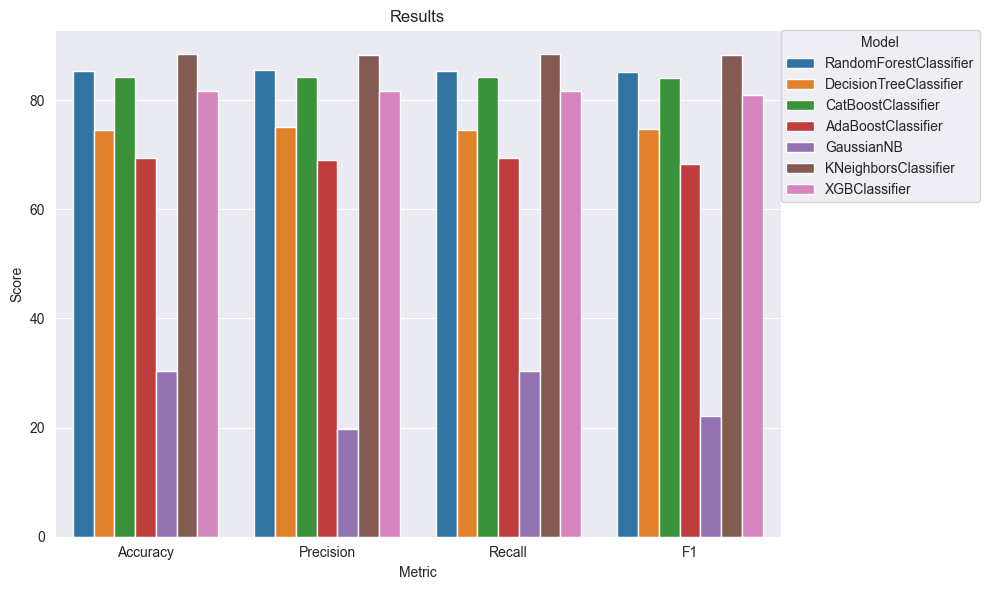

In [32]:
melted_df = d.melt(id_vars="Name", value_vars=["Accuracy", "Precision", "Recall", "F1"], var_name="Metric")

# Create result barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_df, x="Metric", y="value", hue="Name")
plt.title("Results")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.legend(title="Model", loc=2, bbox_to_anchor=(1, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

### <u>Results and Discussion</u>

#### EDA

EDA on the Boston crime dataset revealed various underlying trends and patterns. The complex nature of this dataset containing 17 features allowed for a rich analysis to be produced. The following sections explore the seasonality analysis, crime trends over the years, types of crimes committed, and hotspot analysis.

#### <u><b>Seasonality analysis</u></b>

Seasonality analysis suggests that most crimes in Boston from 2015-2018 took place between 4pm-6pm, with most crimes occurring on Fridays. Crimes were least likely to occur on Sundays and in the early morning from 3am-5am. The data suggests that most crimes in Boston took place in August and July, and that the years 2018 and 2015 saw a reduction in crime. This cannot be assumed to be true, as this crime dataset recorded data from June 2015 to September 2018, meaning we have a full years worth of data for 2017 and 2016 and half a years worth of data for 2018 and 2015. Hence, we are missing data from Jan 2015 - May 2015 and October 2018 - Dec 2018. The least crime is committed in the months of December, January, and February. 

#### <u><b>Yearly crime trends</u></b>

Most crimes taking place in Boston between 2015 and 2018 were classified as Part 3 crimes. Part One crimes are listed as the most severe, with Part Three crimes as the least severe. Examples of Part One crimes include aggravated assault, auto theft, and homicides. Part Two crimes include drug violations, fraud, and vandalism. Finally, Part Three crimes include towing and license violations. There are more petty crimes than severe crimes such as homicides, which explains why there is a significant difference in Part One crimes compared with Part Three crimes.

Crimes are peaking in June, July, and August. .....

#### <u><b>Types of crimes committed</u></b>

There are 67 unique categories of crimes committed. Examples include homicides, larceny, and human trafficking. The top 5 crimes in Boston for these years were: Motor vehicle accident responses, larceny, medical assistance crimes, investigate person, and other. Larceny refers to the theft of personal property. These results suggest that robbery and theft are crimes that the Chicago police department need to actively prevent. Motor vehicle accident responses are the most common crime in Boston, which could suggest that many people are unequipped to operate a vehicle. This could be due to driving under the influence of alcohol or drugs, speeding, or loss of vehicle control. 

#### <u><b>Hotspot analysis</u></b>

A hotspot analysis was conducted to reveal the most dangerous areas in Boston from 2015 - 2018. As crimes are recorded at the incident level, one must first group various areas of crime together for the analysis to be useful. A crime heatmap was then created to depict the total crime counts per area, revealing that Washington Street, Blue Hill Avenue, and Bolyston Street were the most dangerous areas in Boston. These results can aid law enforcement in focusing on these areas through efficient police resource utilization. This prevents police resources from being wasted on areas with low crime.

#### Machine Learning

The structure of the Boston dataset is similar to the Chicago crime dataset. The majority of crime forecasting systems in literature have used similar datasets in terms of structure, features, and number of data points. The Boston dataset contains 17 features, allowing for robust crime forecasting models to be implemented for use in prediction.

This experiment aimed to predict the district of each crime committed, given the hour, crime severity, reporting area, month, day, and hour. This feature selection is credited to Anuvarshini et al paper, where they used the same features to achieve high accuracies. Latitude and longitude were excluded as they are highly correlated with district, meaning these coordinates directly predict the district. The results of this experiment are explored in the following sections.

<table border="1" class="dataframe">
<caption style='margin:20px;background-color:cyan; color:black';><b>Table 1: Performance metrics of various classifiers on the Boston dataset</b></caption>
  <thead>
    <tr style="text-align: right;">
      <th>Ranking</th>
      <th>Name</th>
      <th>Accuracy</th>
      <th>Precision</th>
      <th>Recall</th>
      <th>F1</th>
    </tr>
  </thead>
 <tbody>
    <tr>
      <th>2</th>
      <td>RandomForestClassifier</td>
      <td>85.45</td>
      <td>85.64</td>
      <td>85.45</td>
      <td>85.18</td>
    </tr>
    <tr>
      <th>5</th>
      <td>DecisionTreeClassifier</td>
      <td>74.54</td>
      <td>75.12</td>
      <td>74.54</td>
      <td>74.66</td>
    </tr>
    <tr>
      <th>3</th>
      <td>CatBoostClassifier</td>
      <td>84.23</td>
      <td>84.29</td>
      <td>84.23</td>
      <td>84.13</td>
    </tr>
    <tr>
      <th>6</th>
      <td>AdaBoostClassifier</td>
      <td>69.49</td>
      <td>68.97</td>
      <td>69.49</td>
      <td>68.32</td>
    </tr>
    <tr>
      <th>7</th>
      <td>GaussianNB</td>
      <td>30.40</td>
      <td>19.81</td>
      <td>30.40</td>
      <td>22.14</td>
    </tr>
    <tr>
      <th>1</th>
      <td>KNeighborsClassifier</td>
      <td>88.40</td>
      <td>88.31</td>
      <td>88.40</td>
      <td>88.28</td>
    </tr>
    <tr>
      <th>4</th>
      <td>XGBClassifier</td>
      <td>81.68</td>
      <td>81.61</td>
      <td>81.68</td>
      <td>81.00</td>
    </tr>
  </tbody>
</table>

All models performed well in predicting a crime's district, with the exception of Gaussian Naive Bayes. The best performing model was k-NN with an accuracy and F1-score of 88.4% and 88.28%, respectively. The worst performing model was Gaussian Naive Bayes, with an accuracy and F1-score of 30.4% and 22.14%, respectively. The remaining models performed within an accuracy range of 69.49% - 85.45%. All models yielded similar precision and recall values when compared to the accuracy achieved. However, the precision of Gaussian Naive Bayes sees a significant decrease compared to its achieved accuracy and recall values, with a low precision score of 19.81%.

Given the above results, a robust crime forecasting system can be developed for Boston using its respective crime dataset. These machine learning models performed the best on the Boston dataset, with the best model achieving an accuracy of 88.4%, as compared to the best model on Chicago achieving an accuracy of 71.16%. Gaussian Naive Bayes performed poorly on all three datasets, possibly due to the lack of class independence. The best F1-score was also achieved by k-NN, with a score of 88.28%. These results indicate that the Boston crime dataset is a good candidate for use in crime forecasting.

Suggestions?

## <center><b>Thanks for reading!</b>